Import Libraries and Keys

In [2]:
import os
from dotenv import load_dotenv
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import openai
import praw
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")


In [4]:
# Set up Reddit API credentials
reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent=os.getenv("USER_AGENT"),
    username=os.getenv("USERNAME"),
    password=os.getenv("PASSWORD"),
)

In [5]:


# List of product names to search for
product_list = ['McAfee']

# Set search query
query = ' OR '.join([f'"{product}"' for product in product_list])

In [19]:
#use chatgpt to figure out if it is about McAfee
subreddit = reddit.subreddit('all')
search_term = 'McAfee'
posts = subreddit.search(search_term, limit=100)  # Adjust the limit as needed

# Filter posts using GPT
relevant_posts = []
notreleveant_posts = []
for post in posts:
    #prompt = f"Is this about McAfee products: \"{post.title}\"? Respond with a single word: 'Yes' or 'No'."
    prompt = f"Without providing any additional context or unnecessary text, is the title \"{post.title}\" primarily about McAfee antivirus software products? Reply only with 'Yes' or 'No'."

    response = openai.Completion.create(engine="text-davinci-002", prompt=prompt, max_tokens=10)

    if response.choices[0].text.strip().lower() == "yes":
        relevant_posts.append(post.title)
    else:
        notreleveant_posts.append(post.title)

print("relevent posts:")
print(relevant_posts)
print("not relevent posts:")
print(notreleveant_posts)

relevent posts:
['Should I use McAfee or just Windows Defender?', 'McAfee having 20+ processes open while being unable to close any of them', 'u/CornDoggyLOL Images Now Being Used by Pat McAfee Show!', 'Worse than McAfee', 'McAfee giving Chrome a run for its money', "I am looking into buying a gaming pc and HP is trying to force me to use McAfee for at least a month, no 'No, thanks' option or anything like that.", "McAfee doesn't allow me to go into the settings and constantly gives me a pop up to use their shit again.", "I roasted McAfee. Also, the reason I took a photo instead of screenshot is because McAfee is so evil that they coded so that you can't take screenshot of the uninstall/feedback screen", 'Thanks for warning me, McAfee', 'McAfee inflates unintall times, to try to make you cancel it. this is after 10 minutes. brand new computer.', 'McAfee was right', 'This McAfee “ad” to make sure you activate it forced into your agenda on every single day… honestly had a laughter attack

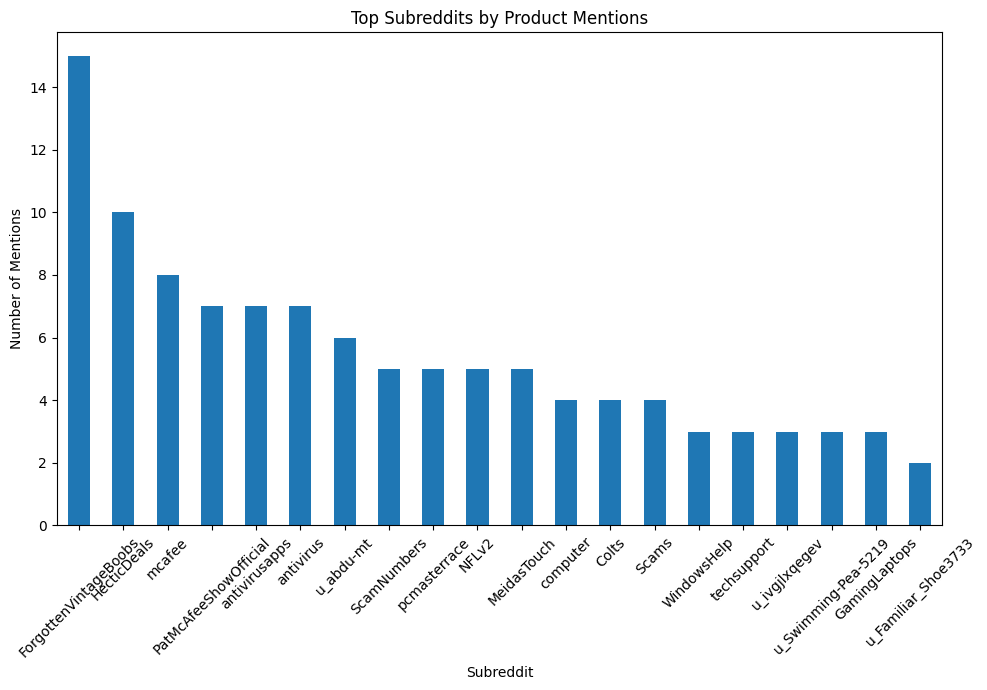

In [20]:
# Find which subreddits these products are seen in

# Dictionary to store counts of mentions by subreddit
subreddit_counts = {}

# Number of posts to search for each product (limitation of the API)
search_limit = 1000

for product in product_list:
    for post in reddit.subreddit("all").search(product, sort="new", time_filter="month", limit=search_limit):
        sub = post.subreddit.display_name
        if sub not in subreddit_counts:
            subreddit_counts[sub] = 0
        subreddit_counts[sub] += 1

# Convert the counts dictionary to a sorted DataFrame
df_counts = pd.DataFrame(list(subreddit_counts.items()), columns=["Subreddit", "Count"]).sort_values(by="Count", ascending=False)

# Visualize the top N subreddits (change N based on your preference)
N = 20
ax = df_counts.head(N).plot(x="Subreddit", y="Count", kind="bar", legend=False, figsize=(10, 7))
ax.set_ylabel("Number of Mentions")
ax.set_xlabel("Subreddit")
ax.set_title("Top Subreddits by Product Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Choose which subredits to search
subreddits_list = ["msp", "techsupport", "cybersecurity", "sysadmin"]

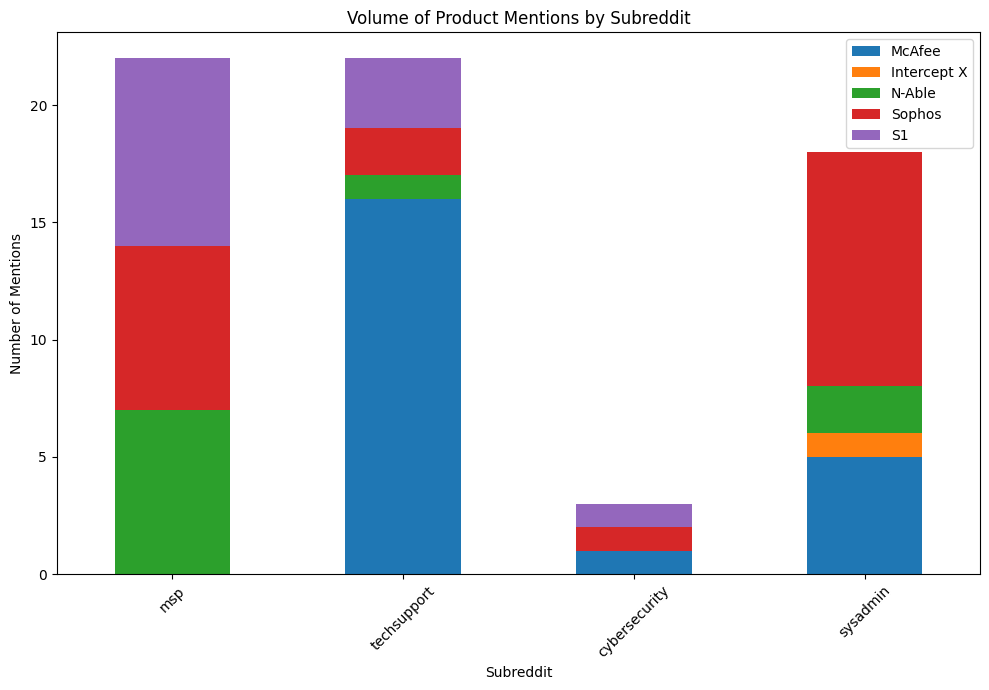

In [22]:
# Show the specific product volume in each sub
# Create a nested dictionary to store counts
counts = {sub: {product: 0 for product in product_list} for sub in subreddits_list}

# Retrieve posts from subreddit and update counts
for sub in subreddits_list:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.search(query, sort="new", time_filter="month"):
        for product in product_list:
            if product.lower() in post.title.lower() or product.lower() in post.selftext.lower():
                counts[sub][product] += 1

# Convert the nested dictionary to a DataFrame
df_counts = pd.DataFrame(counts).T

# Plotting the data as a stacked bar chart
ax = df_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
ax.set_ylabel("Number of Mentions")
ax.set_xlabel("Subreddit")
ax.set_title("Volume of Product Mentions by Subreddit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

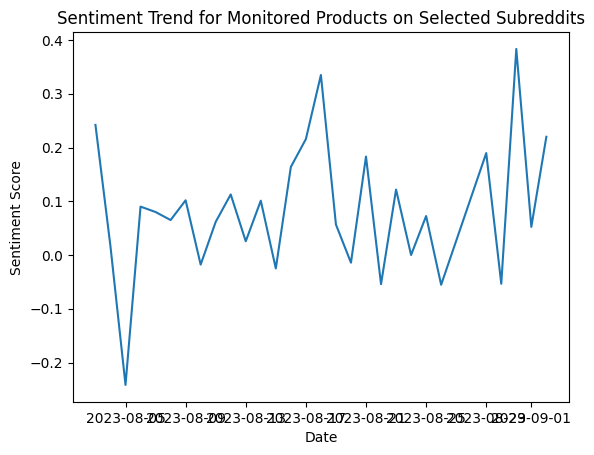

In [24]:
#trend the sentiment

# Retrieve posts from subreddit
posts = []
for sub in subreddits_list:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.search(query, sort="new", time_filter="month"):
        posts.append([post.title, post.selftext, post.created_utc])

# Filter posts that contain the products
product_posts = []
for post in posts:
    # Check if post title or text contains any of the products
    if any(product.lower() in text for text in [post[0].lower(), post[1].lower()] for product in product_list):
        product_posts.append(post)

# Analyze sentiment of filtered posts
sentiments = []
for post in product_posts:
    blob = TextBlob(post[0] + " " + post[1])
    sentiment = blob.sentiment.polarity
    sentiments.append([post[2], sentiment])

# Convert sentiment data to DataFrame
df = pd.DataFrame(sentiments, columns=["timestamp", "sentiment"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s").dt.date

# Calculate average sentiment score for each day
df = df.groupby("date").mean().reset_index()

# Plot sentiment trend over time
plt.plot(df["date"], df["sentiment"])
plt.title("Sentiment Trend for Monitored Products on Selected Subreddits")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.show()
